In [1]:
# ****************** GENERAL IMPORTS **************************
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import scipy.ndimage as ndi
# *************************************************************

In [ ]:
from models.zf_unet.zf_unet_224_model import ZF_UNET_224

In [5]:
filenames = glob.glob(os.path.join('../data/test_224', '*'))
selection = filenames[:10]

In [6]:
model = ZF_UNET_224()
model.load_weights('./weights_224_100epochs/temp.99--1.94.hdf5')

In [8]:
imgs = []
for fname in selection:
    imgs.append(io.imread(fname))
imgs = np.asarray(imgs)

In [12]:
masks = model.predict_on_batch(imgs)
print(masks.shape)

(10, 224, 224, 1)


In [22]:
masks_bin = np.squeeze(masks) > 0.5

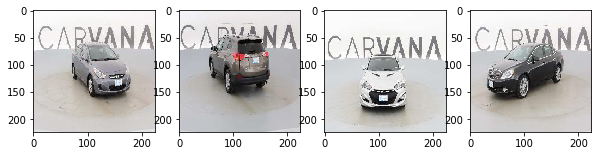

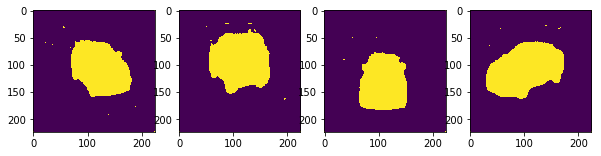

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 30))
for idx, img in enumerate(imgs[:4]):
    axes[idx].imshow(img)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 30))
for idx, mask in enumerate(masks_bin[:4]):
    axes[idx].imshow(mask)

    plt.show()

# print(imgs.shape, masks.shape)
# print(imgs[0].shape, masks[0].shape)
# plt.imshow(masks[0])

In [ ]:
df = pd.read_csv('../submissions/02_fixed.gz', nrows=100)
df.head()

In [26]:
rle = df['rle_mask'][90].split(' ')

SHAPE = (1280, 1913)

mask = np.zeros(SHAPE[0]*SHAPE[1], dtype=np.uint8)

for i in range(0, len(rle)-1, 2):
    idx_s, n = int(rle[i]) - 1, int(rle[i+1])
    idx_e = idx_s + n
    mask[idx_s:idx_e] = 255

uint8


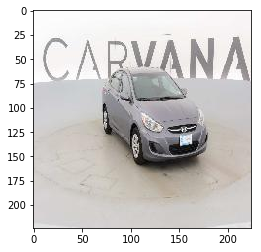

error: /build/opencv/src/opencv-3.2.0/modules/imgcodecs/src/loadsave.cpp:531: error: (-2) could not find a writer for the specified extension in function imwrite_


In [38]:
img_name = df['img'][0]
img = cv2.imread('../data/test_224/{}'.format(img_name))
print(img.dtype)
plt.imshow(img[:, :, ::-1])
plt.show()
cv2.imwrite('lul.gif', img[:, :, 0])

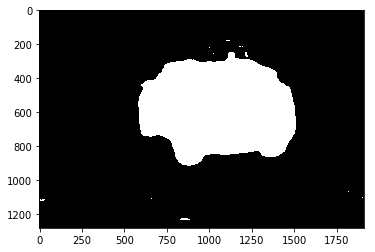

116014545


In [27]:
mask = mask.reshape(SHAPE)
plt.imshow(mask, cmap=plt.cm.gray)
plt.show()
print(np.sum(mask))

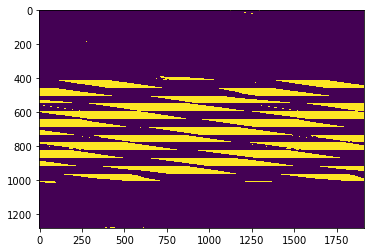

In [32]:
temp = mask.flatten('F').reshape(SHAPE)
plt.imshow(temp)
plt.show()

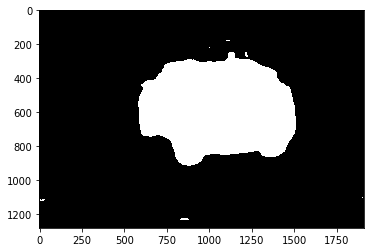

In [29]:
struct = ndi.iterate_structure(ndi.generate_binary_structure(2, 1), 2)
mask_open = ndi.binary_opening(mask, struct)
plt.imshow(mask_open, cmap=plt.cm.gray)
plt.show()

In [31]:
from utils import _mask_to_rle_string
rle_raw = _mask_to_rle_string(mask)
rle_open = _mask_to_rle_string(mask_open)
print(len(rle_raw), len(rle_open))
print(800/13400)

13431 12636
0.05970149253731343


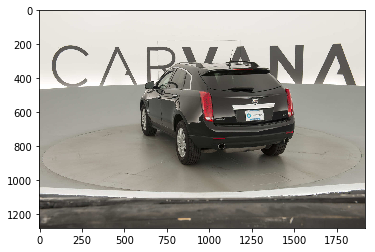

In [25]:
imgname = df['img'][90]
img = io.imread('../data/test/{}'.format(imgname))
plt.imshow(img)
plt.show()

(224, 224)


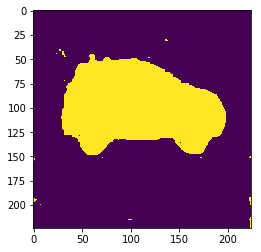

uint8
0


In [82]:
img = cv2.imread('../data/predicts_224/13987558f6b2_13.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow((img >= 1).astype(np.uint8))
plt.show()
print(img.dtype)
print(np.min(img))

[[False False  True False False]
 [False  True  True  True False]
 [ True  True  True  True  True]
 [False  True  True  True False]
 [False False  True False False]]


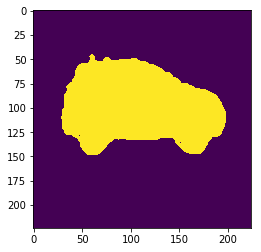

In [83]:
struct = ndi.morphology.generate_binary_structure(2, 1)
struct = ndi.morphology.iterate_structure(struct, 2)
print(struct)

img_bin = img >= 1
img_fixed = ndi.morphology.binary_opening(img_bin, struct)
plt.imshow(img_fixed)
plt.show()

In [84]:
mask_up = cv2.resize(img_fixed.astype(np.uint8), (1913, 1280))

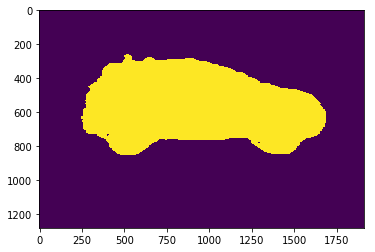

[0 1]


In [85]:
plt.imshow(mask_up)
plt.show()
print(np.unique(mask_up))

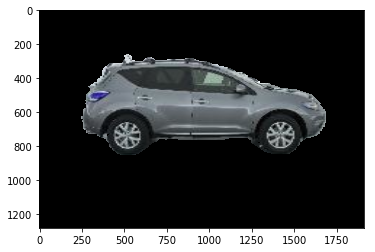

In [87]:
img = cv2.imread('../data/test_224/13987558f6b2_13.jpg')
img_up = cv2.resize(img, (1913, 1280))
img_up[np.where(mask_up==0)] = 0
plt.imshow(img_up)
plt.show()

|

|

|

|

|

|

|

|

|

|

|

In [5]:
fnames_in_224 = sorted(glob.glob('../data/test_224/*.jpg'))
# fnames_out_224 = sorted(glob.glob('../data/predicts_224/*.jpg'))

In [6]:
idxs = np.random.randint(0, len(fnames_in_224), 10)
sel_in = [fnames_in_224[i] for i in idxs]
sel_out = [fnames_out_224[i] for i in idxs]

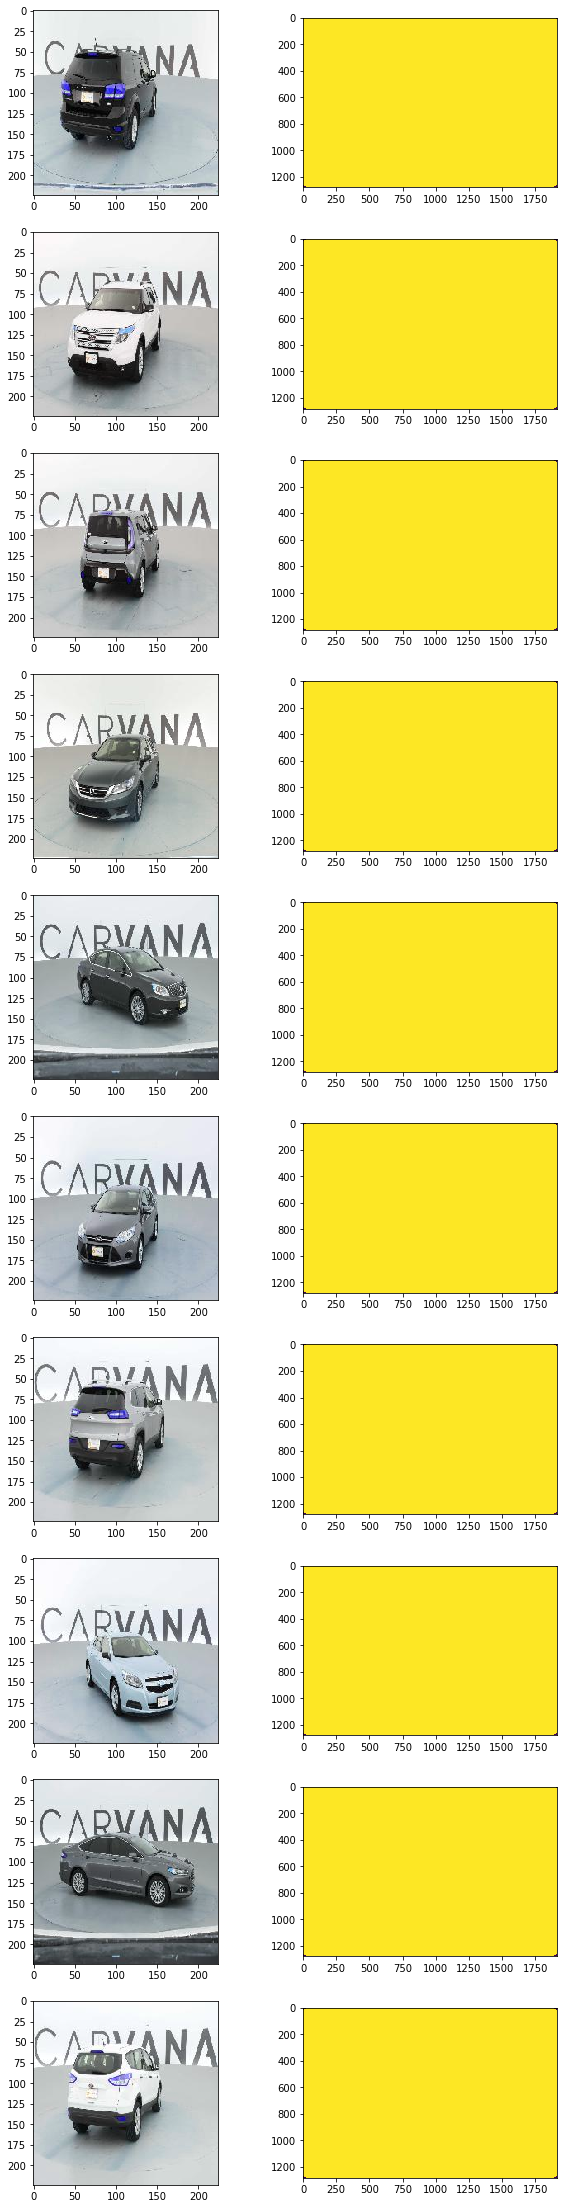

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=len(idxs), figsize=(10, 40))

for idx, (f_i, f_o) in enumerate(zip(sel_in, sel_out)):
    img = cv2.imread(f_i, cv2.IMREAD_COLOR)
    mask = cv2.imread(f_o, cv2.IMREAD_GRAYSCALE)
    
    axes[idx, 0].imshow(img)
    # axes[idx, 1].imshow(mask)
    mask = mask >= 1
    mask = ndi.filters.median_filter(mask, size=7, mode='constant', cval=False)
    mask = cv2.resize(mask.astype(np.uint8), (1913, 1280))
    #mask = cv2.resize(mask.astype(np.ubyte), (1913, 1280))
    axes[idx, 1].imshow(mask)
    
    #print(np.unique(mask))
    #print(np.min(mask), np.max(mask))

plt.show()

[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]


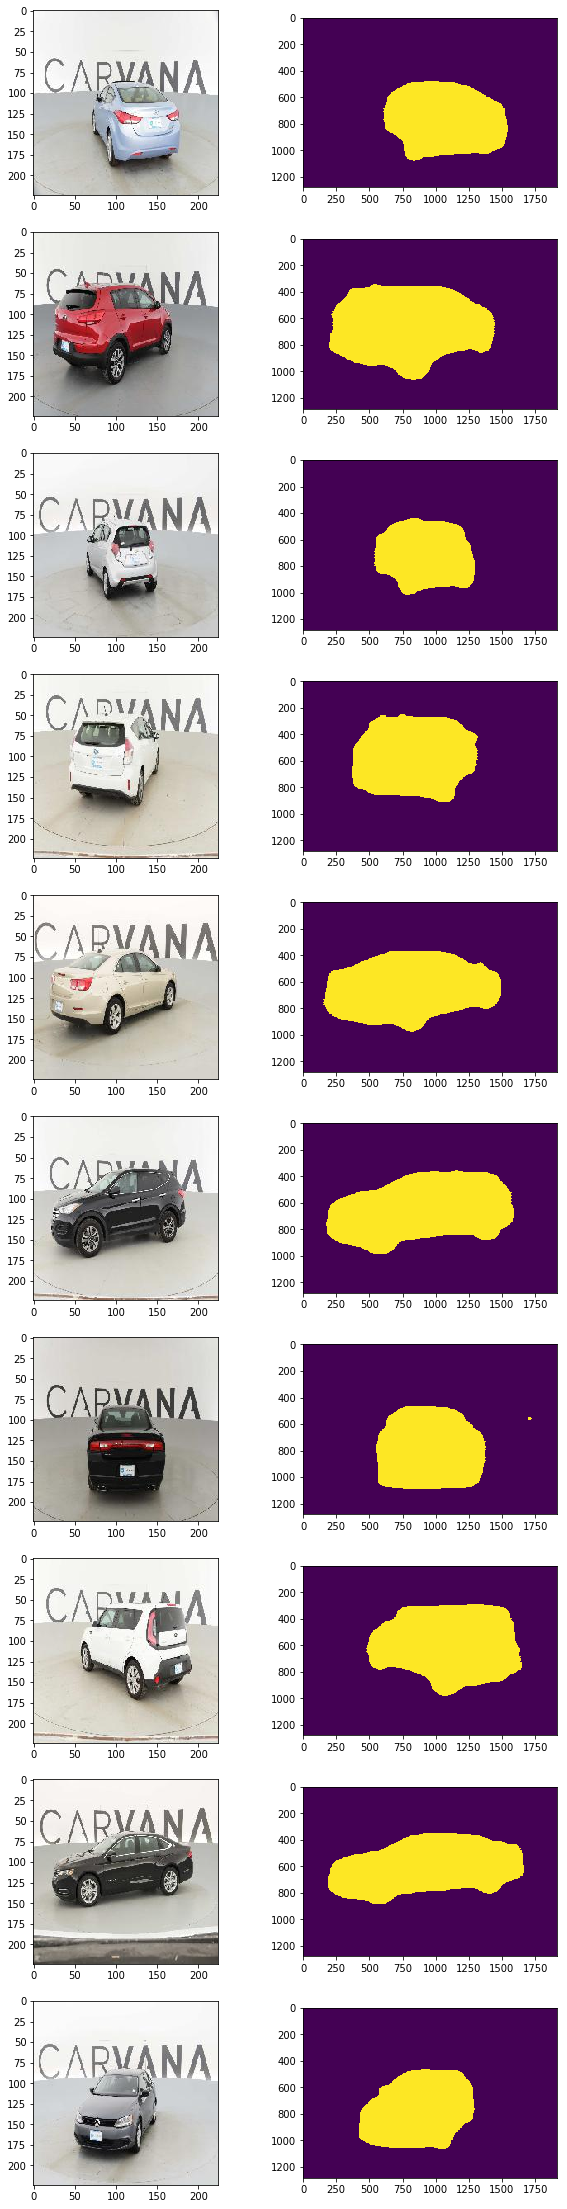

In [10]:
fnames_in_224 = sorted(glob.glob('../data/test_224/*.jpg'))
fnames_out_224 = sorted(glob.glob('../data/predicts_224/*.jpg'))

idxs = np.random.randint(0, len(fnames_in_224), 10)
sel_in = [fnames_in_224[i] for i in idxs]
sel_out = [fnames_out_224[i] for i in idxs]

fig, axes = plt.subplots(ncols=2, nrows=len(idxs), figsize=(10, 40))

for idx, (f_i, f_o) in enumerate(zip(sel_in, sel_out)):
    img = cv2.imread(f_i, cv2.IMREAD_COLOR)[:, :, ::-1]
    mask = cv2.imread(f_o, cv2.IMREAD_GRAYSCALE)
    
    axes[idx, 0].imshow(img)
    # axes[idx, 1].imshow(mask)
    mask = np.not_equal(mask, 0)
    mask = ndi.filters.median_filter(mask, size=7, mode='constant', cval=False)
    mask = cv2.resize(mask.astype(np.uint8), (1913, 1280))
    mask = np.not_equal(mask, 0)
    #mask = cv2.resize(mask.astype(np.ubyte), (1913, 1280))
    axes[idx, 1].imshow(mask)
    
    print(np.unique(mask))
    #print(np.min(mask), np.max(mask))

plt.show()